The definition of a \emph{copula} is: a multivariate distribution $C(U_1, U_2, \ldots, U_n)$ such that marginalizing gives $U_i \approx$~Uniform(0,1). 
Despite this obscure and daunting sentence the concept is quite simple so let's try to clarify it a bit and at the end we will see what role copulas played in the 2008 financial crisis.

### Example Problem Case
Imagine we measure two variables that are non-normally distributed and correlated. For example, we look at various rivers and for every river we look at the maximum level of that river over a certain time-period. In addition, we also count how many months each river caused flooding. For the probability distribution of the maximum level of the river we know that maximums are \href{}{\emph{Grumbel}} distributed, while the number of flooding can be modelled according to a \href{}{\emph{Beta}} distribution.

Clearly it is pretty reasonable to assume that the maximum level and the number of floodings is going to be correlated, however we don't know how we could model that correlated probability distribution. Above we only specified the distributions for individual variables, irrespective of the other one (i.e. the marginals), in reality we are dealing with a joint distribution of both of these together. 

And here is where copulas come to our rescue.

Copulas essentially allow to decompose a joint probability distribution into their marginals (which by definition have no correlation) and a function which couples (hence the name) them together and thus allows us to specify the correlation separately. The copula is that coupling function.

Before going into them, we must first learn how we can transform arbitrary random variables to uniform and back.

### Distribution Transformation
The technique we are going to use to transform every random variables to uniform and viceversa is called \emph{probability integral transform}. We won't go into the details but we will just show few examples of how this can be done in \texttt{python} and we will use the \texttt{scipy.stats} module to do the job.

So first, we sample uniformly distributed values between 0 and 1:

In [2]:
from scipy import stats
from matplotlib import pyplot as plt

x = stats.uniform(0, 1).rvs(10000)

plt.hist(x)
plt.show()

<Figure size 640x480 with 1 Axes>

Next we want to transform these samples so that instead of uniform they are normally distributed. The transform that does this is the inverse of the cumulative density function (CDF) of the normal distribution which we can get in \texttt{scipy.stats} with \texttt{ppf}.

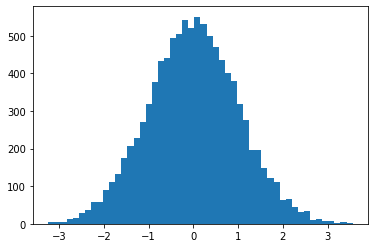

In [3]:
norm = stats.distributions.norm() # get the normal distribution definition
x_trans = norm.ppf(x)

plt.hist(x_trans, bins=50)
plt.show()

If we plot them togheter in a 2D plot we can get a sense of what is going on using the inverse CDF transformation:

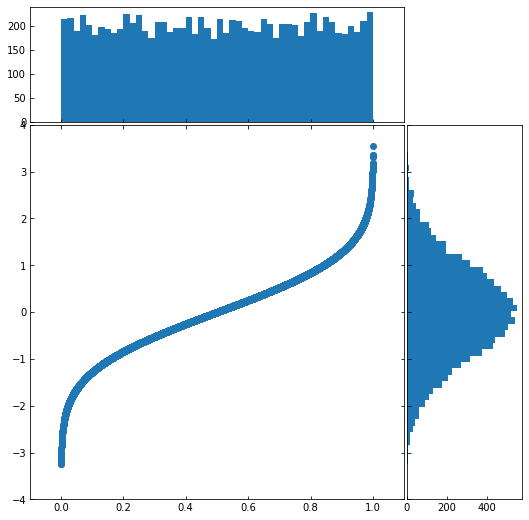

In [4]:
import numpy as np

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(x, x_trans)

ax_scatter.set_xlim((-0.1, 1.1))
ax_scatter.set_ylim((-4, 4))

ax_histx.hist(x, bins=50)
ax_histy.hist(x_trans, bins=50, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

The inverse CDF stretches the outer regions of the uniform to yield a normal distribution. The nice thing of the technique is that it can be done for any arbitrary (univariate) probability distributions, like Beta or Gumbel:

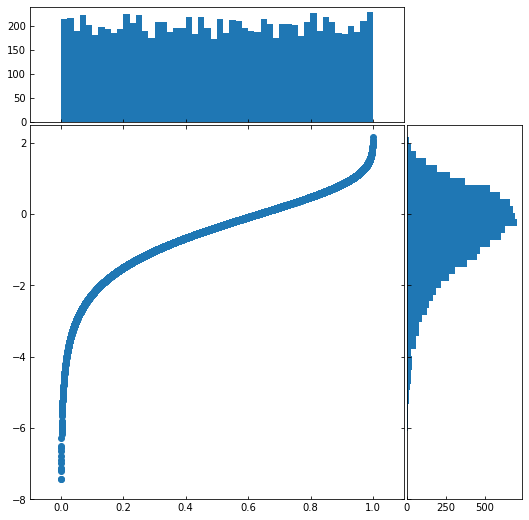

In [5]:
gumbel = stats.distributions.gumbel_l()
x_trans = gumbel.ppf(x)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(x, x_trans)

ax_scatter.set_xlim((-0.1, 1.1))
ax_scatter.set_ylim((-8, 2.5))

ax_histx.hist(x, bins=50)
ax_histy.hist(x_trans, bins=50, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

Clearly to do the opposite transformation from an arbitray distribution to the uniform(0, 1) we can just apply the inverse of the inverse CDF, the CDF itself...

## Adding Correlation with Gaussian Copulas

How does this help us with our problem of creating a custom joint probability distriution ? We are actually almost done already, we know how to convert anything uniformly distributed to an arbitrary probability distribution. So that means we need to generate uniformly distributed data with the correlation we want and then transform the marginals into the desired distributions. How do we do that ? We simulate from a multivariarte Gaussian with the specific corrrelation structure, transform so that the marginals are uniform, and then transform the uniform marginals to whatever we like.

Generate random samples from multivariate normal with correlation .5:

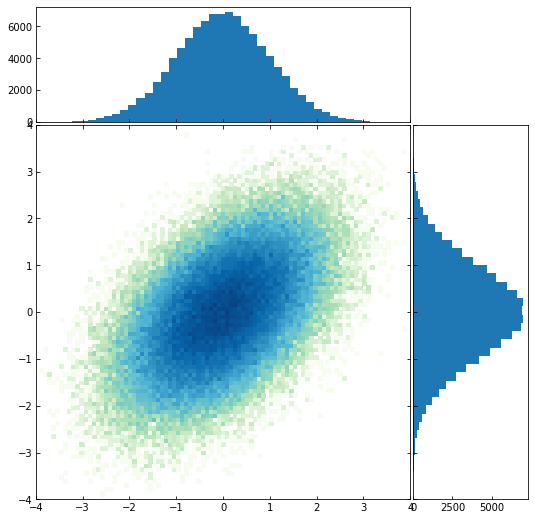

In [9]:
# this import is for plotting
from matplotlib import colors

mvnorm = stats.multivariate_normal(mean=[0, 0] , cov=[[1, 0.5],
                                                      [0.5, 1]])
x = mvnorm.rvs(100000)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.hist2d(x[:, 0], x[:, 1], bins=100, norm=colors.LogNorm(), cmap="GnBu")

ax_scatter.set_xlim((-4, 4))
ax_scatter.set_ylim((-4, 4))

ax_histx.hist(x[:, 0], bins=50)
ax_histy.hist(x[:, 1], bins=50, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

Now use what we have just seen to \emph{uniformify} the marginals:

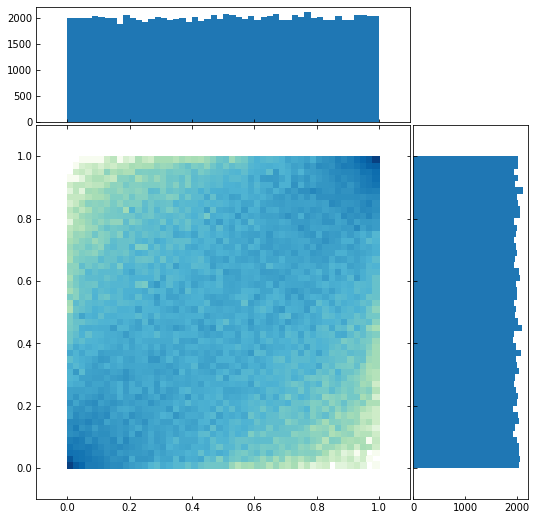

In [58]:
norm = stats.norm()
x_unif = norm.cdf(x)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.hist2d(x_unif[:, 0], x_unif[:, 1], bins=50, norm=colors.LogNorm(), cmap="GnBu")

ax_scatter.set_xlim((-0.1, 1.1))
ax_scatter.set_ylim((-0.1, 1.1))

ax_histx.hist(x_unif[:, 0], bins=50)
ax_histy.hist(x_unif[:, 1], bins=50, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

This scatter plot above is usually how copulas are visualized.
Finally we can just transform the marginals again from uniform to what we want (e.g. Gumbel and Beta): 

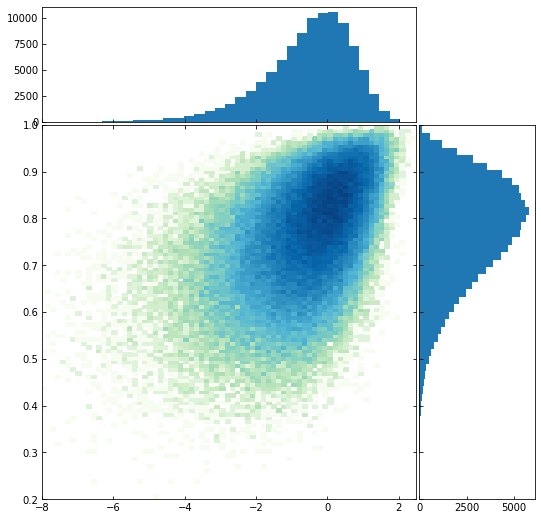

In [56]:
m1 = stats.gumbel_l()
m2 = stats.beta(a=10, b=3)

x1_trans = m1.ppf(x_unif[:, 0])
x2_trans = m2.ppf(x_unif[:, 1])

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.hist2d(x1_trans, x2_trans, bins=100, norm=colors.LogNorm(), cmap="GnBu")

ax_scatter.set_xlim((-8, 2.5))
ax_scatter.set_ylim((0.2, 1))

ax_histx.hist(x1_trans, bins=50)
ax_histy.hist(x2_trans, bins=50, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

It is now interesting to compare with the joint distribution without correlations:

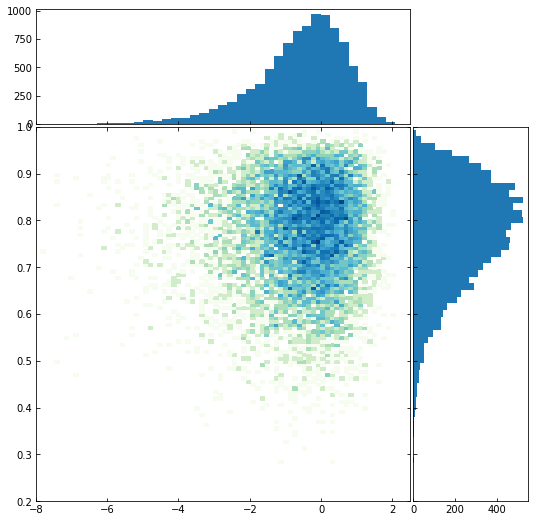

In [55]:
x1 = m1.rvs(10000)
x2 = m2.rvs(10000)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.hist2d(x1, x2, bins=100, norm=colors.LogNorm(), cmap="GnBu")

ax_scatter.set_xlim((-8, 2.5))
ax_scatter.set_ylim((0.2, 1))

ax_histx.hist(x1, bins=50)
ax_histy.hist(x2, bins=50, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

Using the uniform distribution as a common base for our transformations we can easily introduce correlations and flexibly construct complex probability distributions. Clearly this is directly extendeable to higher dimensional distributions as well.

## Application to Finance
In credit derivative valuation and credit risk management, one of the fundamentally important issues is the estimation of default probabilities and their correlations. For this, generally speaking, there are two ways: using historical default data or using mathematical models. 

Historical default data has played an important role in the estimation of default probabilities. However, because default events are rare, there is very limited default data available. Moreover, historical data reflects the historical default pattern only and it may not be a proper indicator of the future. This makes the estimation of default probabilities from historical data difficult and inexact. To use this same data to estimate default correlations is even more difficult and more inexact. 

The market trend now is towards more and more to the use of mathematical models that don't rely on historical default data. In the previous chapter we have seen how it is possible to derive default probabilities from market data. Before going into the details of the application of the copula to default probabilities let's introduce two more kind of contracts.

### Basket Default Swaps
A basket default swap is a credit derivative on a portfolio of reference entities. The
simplest basket default swaps are first-to-default swaps, second-to-default swaps,
and nth-to-default swaps. With respect to a basket of reference entities, a first-to-default swap provides insurance for only the first default, a second-to-default swap
provides insurance for only the second default, an nth-to-default swap provides
insurance for only the nth default. For example, in an nth-to-default swap, the
protection seller does not make a payment to the protection buyer for the first n−1
defaulted reference entities, and makes a payment for the nth defaulted reference
entity. Once there is a payment upopn the default of the nth defaulted reference
entity, the swap terminates. 

### Collateralized Debt Obligation
A collateralized debt obligation (CDO) is a security backed by a diversified pool of
one or more kinds of debt obligations such as bonds, loans, credit default swaps or
structured products (mortgage-backed securities, asset-backed securities, and even
other CDOs). A CDO can be initiated by one or more of the following: banks,
nonbank financial institutions, and asset management companies, is referred to as
the sponsor. The sponsor of a CDO creates a company so-called the special purpose
vehicle (SPV). The SPV works as an independent entity. In this way, CDO investors
are isolated from the credit risk of the sponsor. Moreover, the SPV is responsible
for the administration. The SPV obtains the credit risk exposure by purchasing
debt obligations (bonds or residential and commercial loans) or selling CDSs; it
transfers the credit risk by issuing debt obligations (tranches/credit-linked notes).
The investors in the tranches of a CDO have the ultimate credit risk exposure to
the underlying reference entities.
The SPV issues four kinds of tranches. Each tranche has
an attachment percentage and a detachment percentage. When the cumulative
percentage loss of the portfolio reaches the attachment percentage, investors
in the tranche start to lose their principal, and when the cumulative percentage loss
of principal reaches the detachment percentage, the investors in the tranche lose all
their principal and no further loss can occur to them.

In the literature, tranches of a CDO are classified as subordinate/equity tranche,
mezzanine tranches, and senior tranches according to their subordinate levels. 
Because the equity tranche is extremely
risky, the sponsor of a CDO holds the equity tranche and the SPV sells other tranches
to investors.

### Calculating first-to-default, nth-to-default and all-to-default probabilities

#### Independent Defaults
If the default times of the names of a basket are independent, first-to-default, nth-to-default, all-to-default probabilities can be calculated through multiplication and integration of the default probability curves of the basket components. 

As an example, we consider the second-to-default probability of a 4-name basket. Let $\tau_i$ be the default time of name $i$ and $F_i(t)$ its distribution. Then the probability that name 1 defaults second in the basket before time $t$ and before the counter-party defaults: 

$$P((\tau_2\lt\tau_1)\cap (\tau_1\lt t)\cap (\tau_1\lt\tau_3)\cap (\tau_1\lt\tau_4)) +
P((\tau_3\lt\tau_1)\cap (\tau_1\lt t)\cap (\tau_1\lt\tau_2)\cap (\tau_1\lt\tau_4)) =
\int_0^t{F_2 (s)\cdot (1-F_3 (s)) \cdot (1-F_4 (s))~dF_1(s)} +  \int_0^t{F_3 (s)\cdot (1-F_2 (s)) \cdot (1-F_4 (s))~dF_1(s)}$$

The formula for nth-to-default probability before the counterparty defaults in a general basket can be derived similarly. However, complexity increases as the number of names increases.
The above method can also apply to derive the formula of all-to-default probability before the counter-party defaults. This is clearly much simpler than the nth-to-default case.

Suppose the default probabilities of three companies, A, B and C are given as in the following table:

\begin{center}
\begin{tabular}[|c|c|c|c|]
time in years & A & B & C \\
\hline
0 & 0 & 0 & 0 \\
1 & 0.022032 & 0.0317 & 0.035 \\
2 & 0.046242 & 0.0655 & 0.075 \\
3 & 0.07266 & 0.1022 & 0.121 \\
4 & 0.101233 & 0.142 & 0.153 \\
5 & 0.131885 & 0.1752 & 0.205 \\
\end{tabular}
\end{center}
and suppose that the default events of the three companies are independent. Using linear interpolation for default probability curves, let's get the table of first-to-default probabilities for the three companies.

<img src="default_A.png">

The default probabilities are linear in each time interval so the integral above can be solved by substitution:

$$ \int_{x_0}^{x_1}{(1-F_B(x))(1-F_C(x))dF_A(x)}$$

Setting $t=m_A x + q_A$ it becomes with $m_A, q_A$ are the parameters of the line joining the default probabilities of company A:

$$ \int_{m_A x_0 + q_A}^{m_A x_1 + q_A}{(1-F_B(x(t)))(1-F_C(x(t)))dt}~~~~~~\textrm{, with}~x(t) = \cfrac{t -q_A}{m_A} $$
and similarly for company B and C.

To convert it into python we can use \texttt{scipy.integrate.quad} to perform the integral and \texttt{numpy.interp} to determine the intermediate default probabilities.

In [15]:
from scipy.integrate import quad
from numpy import interp

default_rates = {"A":(0, 0.022032, 0.046242, 0.07266, 0.101233, 0.131885), # company A
                 "B":(0, 0.0317, 0.0655, 0.1022, 0.142, 0.1752), # company B
                 "C":(0, 0.035, 0.075, 0.121, 0.153, 0.205)} # company C

def func(x, default, companies, t):
    m = default[companies[0]][t] - default[companies[0]][t-1]
    q = default[companies[0]][t-1] - m * (t-1)
    t = (x-q)/m
    F2 = 1 - interp(t, range(len(default[companies[1]])), default[companies[1]])
    F3 = 1 - interp(t, range(len(default[companies[2]])), default[companies[2]])
    return F2*F3

def integral(default, companies, t):
    return quad(func, 0, default[companies[0]][t], args=(default, companies, t))[0]
                 
for companies in [("A", "B", "C"), ("B", "A", "C"), ("C", "A", "B")]:
    prob = 0
    for t in range(1, 6):
        prob = integral(default_rates, companies, t)
        print ("First to default prob at time ({}) for company {}: {:.5f}".format(t, companies[0], prob))


First to default prob at time (1) for company A: 0.02131
First to default prob at time (2) for company A: 0.04301
First to default prob at time (3) for company A: 0.06460
First to default prob at time (4) for company A: 0.08573
First to default prob at time (5) for company A: 0.10606
First to default prob at time (1) for company B: 0.03080
First to default prob at time (2) for company B: 0.06160
First to default prob at time (3) for company B: 0.09245
First to default prob at time (4) for company B: 0.12315
First to default prob at time (5) for company B: 0.15018
First to default prob at time (1) for company C: 0.03407
First to default prob at time (2) for company C: 0.07071
First to default prob at time (3) for company C: 0.10986
First to default prob at time (4) for company C: 0.13879
First to default prob at time (5) for company C: 0.17011


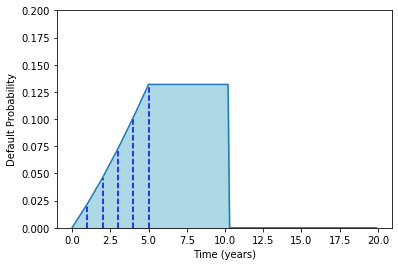

In [14]:
from scipy.stats.distributions import rv_continuous
from scipy.interpolate import interp1d
from scipy.integrate import quad
from matplotlib import pyplot as plt

import numpy as np

class MyDistribution(rv_continuous):
    def __init__(self, limits):
        rv_continuous.__init__(self)
        self.xmax = 1e10
        self.limits = limits
        self.interpolator = interp1d(range(len(self.limits)), self.limits, fill_value='extrapolate')
        temp = (1 - self._cdf(len(self.limits)-1)[0])/self.limits[-1]
        self.xmax = temp + len(self.limits)-1
        x = list(range(len(self.limits))) + [self.xmax]
        self.limits.append(self.limits[-1])
        self.interpolator = interp1d(x, self.limits)
        
    def _cdf(self, x, *args):
        if x<0 or x>self.xmax:
            return 0
        return quad(self.interpolator, 0, x)
    
    def _pdf(self, x, *args):
        if isinstance(x, np.ndarray):
            x[x>self.xmax] = 0
            x[x<0] = 0
            return self.interpolator(x)
        elif x<0 or x>self.xmax:
            return 0
        else:
            return self.interpolator(x)

default_curves = {"A":[0, 0.022032, 0.046242, 0.07266, 0.101233, 0.131885], # company A
                  "B":[0, 0.0317, 0.0655, 0.1022, 0.142, 0.1752], # company B
                  "C":[0, 0.035, 0.075, 0.121, 0.153, 0.205]} # company C

x_A = MyDistribution(default_curves["A"])  
distribution = np.arange(0, 20, 0.1)
for i in range(1, 6):
    plt.vlines(i, 0, x_A.pdf(i), linestyles="--", colors="blue")
plt.plot(distribution, x_A.pdf(distribution))
plt.fill_between(distribution, x_A.pdf(distribution), color="lightblue")
plt.ylim(0, 0.20)
plt.xlabel("Time (years)")
plt.ylabel("Default Probability")
plt.show()

In [54]:
import random

x_A = MyDistribution(default_curves["A"])  
x_B = MyDistribution(default_curves["B"])  
x_C = MyDistribution(default_curves["C"])

random.seed(1)
trials = 0
default_A = 0
for i in range(0, 1):
    #j=1
    #print (cdf_a)
    for k in range(100000):
        j = random.uniform(0.0001, 1)
        cdf_a = x_A.cdf(j)
        cdf_b = x_B.cdf(j)
        cdf_c = x_C.cdf(j)
    
        trials += 1
        a, b, c = random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)
        #print (a, x_A.cdf(1))
        if a < cdf_a and b > cdf_b and c > cdf_c:
            default_A += 1
                
    print (default_A, trials, default_A/trials)
#First to default prob at time (1) for company A: 0.02131
#First to default prob at time (2) for company A: 0.04301
#First to default prob at time (3) for company A: 0.06460
#First to default prob at time (4) for company A: 0.08573
#First to default prob at time (5) for company A: 0.10606

365 100000 0.00365


#### Correlated Defaults
However, if the default times are not independent, no simple formulas are available for these types of probabilities. Monte Carlo simulation is generally used instead. To generate default scenarios we need a model for default times. The most popular models are the Brownian motion credit index process and the normal copula.




## Complex Correlation Structures and the Financial Crisis

In the example above we have used the multivariate normal which gave rise to the Gaussian copula.However, we can use other and more complex copulas as well. For example we might want to assume the correlation is non-symmetruc which is useful in quant finance where correlations become very strong during market crashes and returns very negative.

Infact, Gaussian copulas are said to have played a key role in the 2008 financial crisis as tail-correlations were severely underestimated. Consider a set of mortgages in CDOs (a particular kind of contract that we are going to see) they are clearly correlated, if one mortgage fails, the likelihood that another failing is increased. In the early 2000s, the banks only knew how to model the marginals of the default rates. An (in)famous paper by Li then suggested to use copulas to model the correlations between those marginals. Rating agencies relied on thid model so heaviy, severely underestimating risk and giving false ratings...

If you are interested in the argument read \href{http://timmurphy.org/2009/07/22/line-spacing-in-latex-documents/}{this paper} for an excellent description of Gaussian copulas and the Financial Crisis which argues that different copula choices would not have made a difference but instead the assumed correlation was way too low.